In [16]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [18]:
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 264175723.85it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 104157948.26it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 100467646.71it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16979080.90it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [19]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [20]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            #nn.Linear(64, 12),  nn.ReLU(True),
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [21]:
!pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [22]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000  val_loss: 0.196  trn_loss: 0.259  (23.62s - 94.48s remaining)
EPOCH: 2.000  val_loss: 0.173  trn_loss: 0.181  (49.68s - 74.52s remaining)
EPOCH: 3.000  val_loss: 0.162  trn_loss: 0.166  (73.94s - 49.29s remaining)
EPOCH: 4.000  val_loss: 0.156  trn_loss: 0.158  (97.88s - 24.47s remaining)
EPOCH: 5.000  val_loss: 0.153  trn_loss: 0.154  (119.70s - 0.00s remaining)


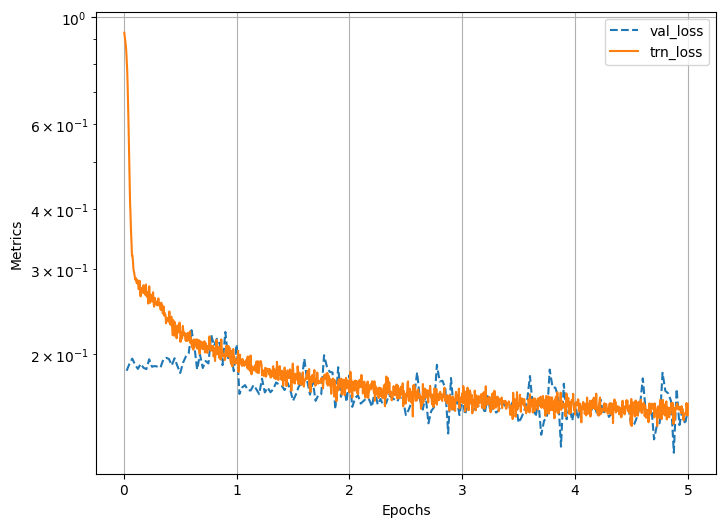

In [23]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9997, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9998,
         -1.0000, -1.0000, -0.9999, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9998],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000,
         -0.9999, -0.9997, -0.9998, -0.9994, -0.9988, -0.9993, -0.9994, -0.9996,
         -0.9983, -0.9998, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -0.9992,
         -0.9956, -0.9914, -0.9924, -0.9870, -0.9844

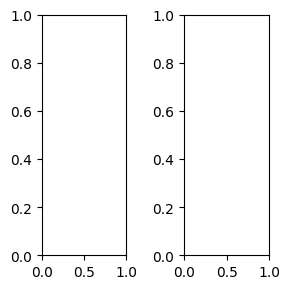

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -0.9998, -0.9997,
         -0.9998, -0.9998, -0.9999, -1.0000, -0.9999, -1.0000, -0.9999, -1.0000,
         -1.0000, -1.0000, -0.9999, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9999, -0.9975, -0.9994, -0.9968, -0.9986, -0.9928, -0.9800, -0.9806,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9997, -0.9996, -0.9995,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9998, -0.9997, -0.9985,
         -0.9945, -0.9898, -0.9894, -0.8960, -0.8122

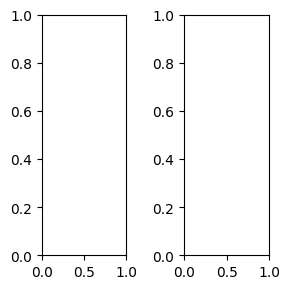

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

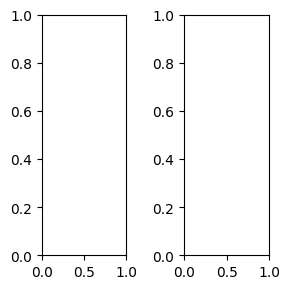

In [24]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

EPOCH: 1.000  val_loss: 0.135  trn_loss: 0.241  (22.44s - 89.75s remaining)
EPOCH: 2.000  val_loss: 0.099  trn_loss: 0.116  (45.79s - 68.68s remaining)
EPOCH: 3.000  val_loss: 0.083  trn_loss: 0.093  (67.04s - 44.69s remaining)
EPOCH: 4.000  val_loss: 0.075  trn_loss: 0.080  (89.21s - 22.30s remaining)
EPOCH: 5.000  val_loss: 0.067  trn_loss: 0.073  (111.71s - 0.00s remaining)


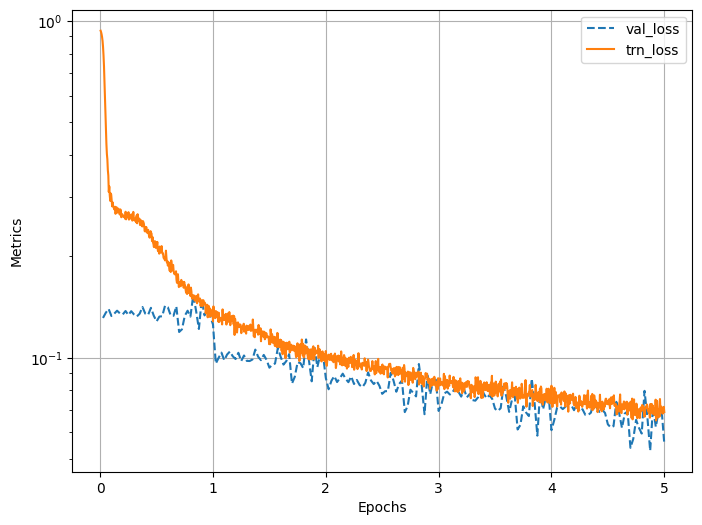

EPOCH: 1.000  val_loss: 0.205  trn_loss: 0.258  (22.10s - 88.40s remaining)
EPOCH: 2.000  val_loss: 0.186  trn_loss: 0.195  (43.11s - 64.67s remaining)
EPOCH: 3.000  val_loss: 0.179  trn_loss: 0.183  (65.37s - 43.58s remaining)
EPOCH: 4.000  val_loss: 0.174  trn_loss: 0.177  (87.71s - 21.93s remaining)
EPOCH: 5.000  val_loss: 0.171  trn_loss: 0.172  (110.01s - 0.00s remaining)


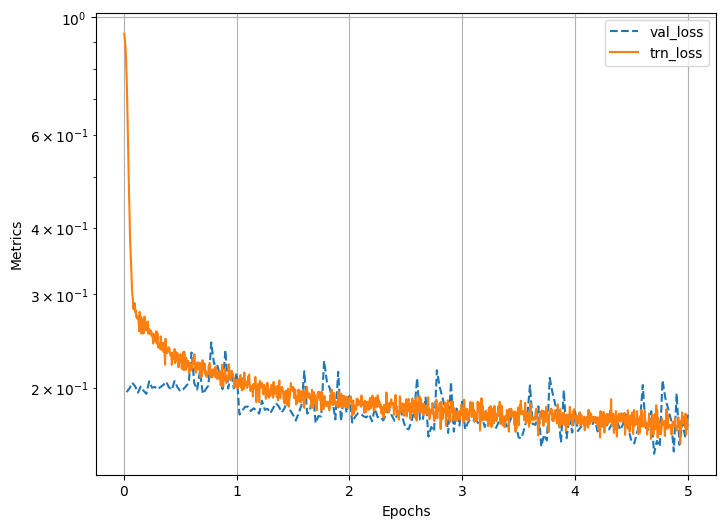

EPOCH: 1.000  val_loss: 0.198  trn_loss: 0.267  (21.54s - 86.17s remaining)
EPOCH: 2.000  val_loss: 0.171  trn_loss: 0.183  (43.69s - 65.53s remaining)
EPOCH: 3.000  val_loss: 0.159  trn_loss: 0.165  (66.27s - 44.18s remaining)
EPOCH: 4.000  val_loss: 0.153  trn_loss: 0.156  (88.54s - 22.13s remaining)
EPOCH: 5.000  val_loss: 0.150  trn_loss: 0.152  (110.24s - 0.00s remaining)


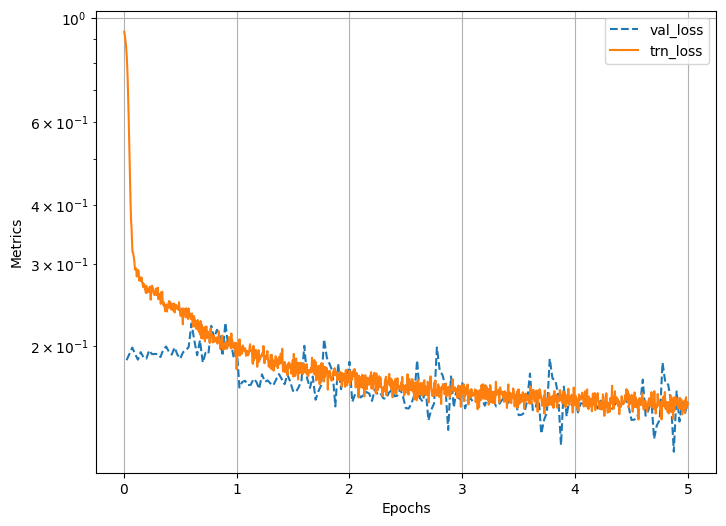

EPOCH: 1.000  val_loss: 0.164  trn_loss: 0.246  (22.51s - 90.02s remaining)
EPOCH: 2.000  val_loss: 0.138  trn_loss: 0.148  (44.96s - 67.43s remaining)
EPOCH: 3.000  val_loss: 0.128  trn_loss: 0.133  (67.11s - 44.74s remaining)
EPOCH: 4.000  val_loss: 0.121  trn_loss: 0.124  (88.69s - 22.17s remaining)
EPOCH: 5.000  val_loss: 0.118  trn_loss: 0.120  (110.27s - 0.00s remaining)


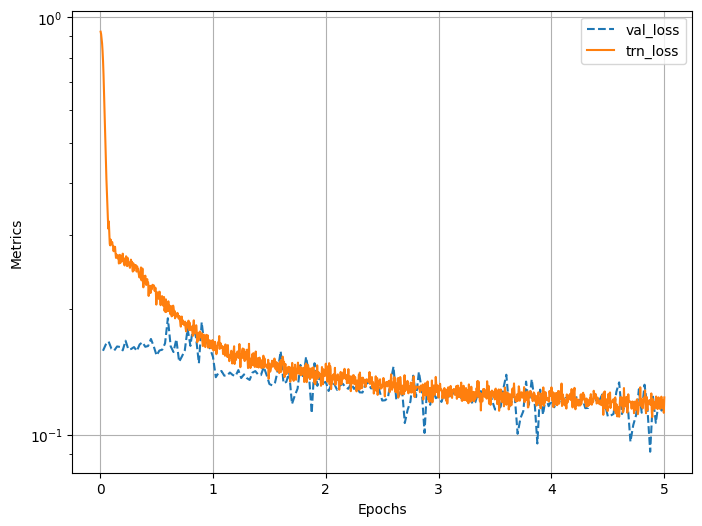

EPOCH: 1.000  val_loss: 0.145  trn_loss: 0.235  (21.91s - 87.65s remaining)
EPOCH: 2.000  val_loss: 0.110  trn_loss: 0.125  (43.55s - 65.33s remaining)
EPOCH: 3.000  val_loss: 0.099  trn_loss: 0.105  (64.89s - 43.26s remaining)
EPOCH: 4.000  val_loss: 0.093  trn_loss: 0.097  (86.98s - 21.75s remaining)
EPOCH: 5.000  val_loss: 0.090  trn_loss: 0.093  (108.75s - 0.00s remaining)


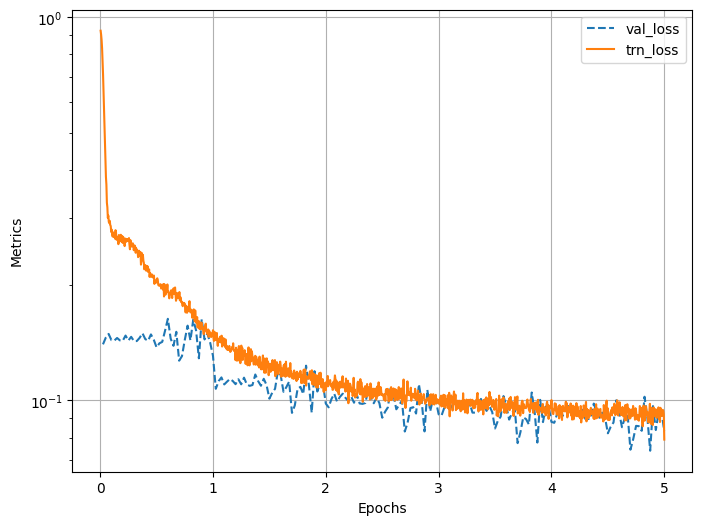

In [25]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-9.9992e-01, -9.9968e-01, -9.9990e-01, -9.9992e-01, -9.9967e-01,
         -9.9977e-01, -9.9972e-01, -9.9984e-01, -9.9969e-01, -9.9978e-01,
         -9.9961e-01, -9.9991e-01, -9.9992e-01, -9.9976e-01, -9.9989e-01,
         -9.9966e-01, -9.9996e-01, -9.9979e-01, -9.9979e-01, -9.9973e-01,
         -9.9978e-01, -9.9978e-01, -9.9976e-01, -9.9981e-01, -9.9974e-01,
         -9.9988e-01, -9.9967e-01, -9.9975e-01],
        [-9.9992e-01, -9.9966e-01, -9.9981e-01, -9.9961e-01, -9.9995e-01,
         -9.9981e-01, -9.9998e-01, -9.9961e-01, -9.9987e-01, -9.9948e-01,
         -9.9962e-01, -9.9936e-01, -9.9923e-01, -9.9879e-01, -9.9948e-01,
         -9.9937e-01, -9.9959e-01, -9.9959e-01, -9.9971e-01, -9.9985e-01,
         -9.9988e-01, -9.9993e-01, -9.9971e-01, -9.9993e-01, -9.9986e-01,
         -9.9993e-01, -9.9993e-01, -9.9978e-01],
        [-9.9982e-01, -9.9990e-01, -9.9992e-01, -9.9962e-01, -9.9978e-01,
         -9.9986e-01, -9.9984e-01, -9.9928e-01, -9.9911e-01, -9.9894e-01,
         -9.98

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.00

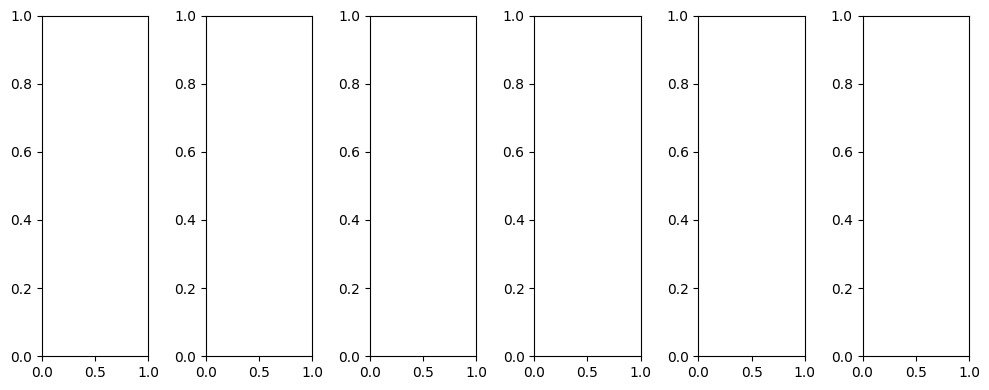

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -9.9999e-01, -9.9999e-01, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -9.9994e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-9.9996e-01, -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9995e-01, -9.9994e-01, -9.9999e-01,
         -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -9.9999e-01, -1.0000e+00, -9.9998e-01, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01,
         -9.9999e-01, -9.9998e-01, -9.9949e-01, -9.9999e-01, -9.9956e-01,
         -9.99

tensor([[-0.9982, -0.9982, -0.9976, -0.9974, -0.9972, -0.9978, -0.9979, -0.9968,
         -0.9976, -0.9972, -0.9967, -0.9975, -0.9970, -0.9973, -0.9964, -0.9973,
         -0.9984, -0.9978, -0.9977, -0.9981, -0.9964, -0.9975, -0.9977, -0.9974,
         -0.9981, -0.9981, -0.9977, -0.9978],
        [-0.9978, -0.9970, -0.9976, -0.9971, -0.9974, -0.9979, -0.9979, -0.9981,
         -0.9975, -0.9963, -0.9955, -0.9952, -0.9948, -0.9932, -0.9922, -0.9932,
         -0.9926, -0.9928, -0.9949, -0.9963, -0.9968, -0.9970, -0.9974, -0.9975,
         -0.9977, -0.9976, -0.9982, -0.9973],
        [-0.9977, -0.9973, -0.9985, -0.9960, -0.9980, -0.9982, -0.9978, -0.9964,
         -0.9929, -0.9939, -0.9939, -0.9946, -0.9900, -0.9913, -0.9862, -0.9844,
         -0.9791, -0.9726, -0.9592, -0.9696, -0.9681, -0.9752, -0.9830, -0.9952,
         -0.9969, -0.9974, -0.9978, -0.9980],
        [-0.9981, -0.9985, -0.9979, -0.9982, -0.9982, -0.9967, -0.9930, -0.9883,
         -0.9895, -0.9492, -0.9201, -0.8677, -0.8106

tensor([[-1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9999,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -0.9999,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9999, -0.9999, -0.9999, -1.0000, -0.9999, -0.9999, -0.9999, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -0.9999, -1.0000,
         -1.0000, -1.0000, -0.9999, -1.0000],
        [-1.0000, -1.0000, -0.9999, -1.0000, -0.9999, -0.9999, -0.9999, -1.0000,
         -1.0000, -0.9998, -0.9999, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9998, -0.9999, -0.9999, -1.0000, -0.9999, -0.9999,
         -1.0000, -1.0000, -0.9999, -1.0000],
        [-0.9999, -0.9999, -1.0000, -0.9999, -1.0000, -1.0000, -0.9993, -0.9914,
         -0.9763, -0.9446, -0.9299, -0.9092, -0.8712

tensor([[-0.9998, -0.9999, -0.9998, -0.9995, -0.9998, -0.9996, -0.9997, -0.9998,
         -0.9999, -0.9996, -0.9999, -0.9995, -0.9995, -0.9999, -0.9998, -0.9996,
         -0.9996, -0.9998, -0.9998, -0.9994, -0.9996, -0.9997, -0.9998, -0.9991,
         -0.9997, -0.9997, -0.9998, -0.9995],
        [-0.9998, -0.9993, -0.9998, -0.9994, -0.9996, -0.9998, -0.9999, -0.9995,
         -0.9998, -0.9995, -0.9998, -0.9997, -0.9997, -0.9999, -0.9999, -0.9998,
         -0.9997, -0.9997, -0.9996, -0.9998, -0.9998, -0.9997, -0.9996, -0.9998,
         -0.9997, -0.9996, -0.9994, -0.9996],
        [-0.9998, -0.9997, -0.9997, -0.9998, -0.9998, -0.9995, -0.9997, -0.9996,
         -0.9997, -0.9996, -0.9998, -0.9997, -0.9999, -0.9999, -1.0000, -0.9961,
         -0.9960, -0.9997, -1.0000, -0.9999, -0.9997, -0.9997, -0.9998, -0.9998,
         -0.9992, -0.9998, -0.9997, -0.9998],
        [-0.9996, -0.9996, -0.9998, -0.9998, -0.9996, -0.9998, -0.9999, -0.9987,
         -0.9981, -0.9951, -0.9896, -0.9861, -0.9829

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9999, -1.0000, -1.0000, -1.0000, -1.0000

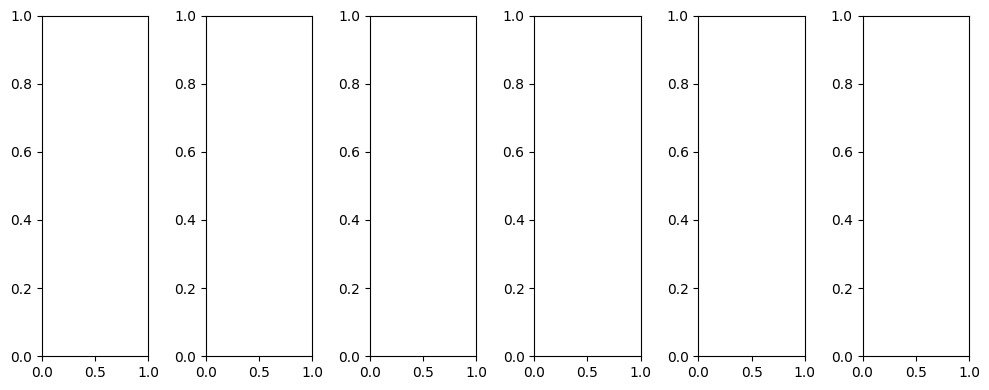

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9999, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9999, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9999, -0.9999, -1.0000, -1.0000

tensor([[-0.9991, -0.9980, -0.9987, -0.9989, -0.9979, -0.9976, -0.9978, -0.9987,
         -0.9974, -0.9976, -0.9949, -0.9988, -0.9980, -0.9974, -0.9980, -0.9981,
         -0.9993, -0.9982, -0.9988, -0.9978, -0.9982, -0.9984, -0.9979, -0.9981,
         -0.9973, -0.9989, -0.9966, -0.9979],
        [-0.9991, -0.9966, -0.9979, -0.9980, -0.9988, -0.9982, -0.9993, -0.9981,
         -0.9979, -0.9972, -0.9971, -0.9980, -0.9975, -0.9943, -0.9953, -0.9970,
         -0.9975, -0.9979, -0.9972, -0.9986, -0.9981, -0.9989, -0.9960, -0.9987,
         -0.9983, -0.9989, -0.9996, -0.9986],
        [-0.9981, -0.9984, -0.9992, -0.9970, -0.9982, -0.9986, -0.9975, -0.9973,
         -0.9965, -0.9980, -0.9972, -0.9987, -0.9965, -0.9977, -0.9960, -0.9954,
         -0.9959, -0.9960, -0.9972, -0.9985, -0.9978, -0.9974, -0.9975, -0.9989,
         -0.9990, -0.9978, -0.9984, -0.9990],
        [-0.9992, -0.9992, -0.9986, -0.9989, -0.9977, -0.9984, -0.9966, -0.9964,
         -0.9957, -0.9854, -0.9858, -0.9647, -0.9636

tensor([[-9.9999e-01, -9.9995e-01, -9.9999e-01, -9.9999e-01, -9.9995e-01,
         -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00, -9.9999e-01,
         -9.9998e-01, -9.9999e-01, -9.9998e-01, -9.9998e-01, -9.9997e-01,
         -9.9991e-01, -9.9999e-01, -9.9999e-01, -9.9997e-01, -9.9995e-01,
         -9.9994e-01, -9.9998e-01, -9.9996e-01, -9.9995e-01, -9.9999e-01,
         -9.9997e-01, -9.9996e-01, -9.9998e-01],
        [-1.0000e+00, -9.9991e-01, -9.9998e-01, -9.9998e-01, -9.9999e-01,
         -1.0000e+00, -9.9998e-01, -9.9999e-01, -9.9989e-01, -9.9996e-01,
         -9.9993e-01, -9.9995e-01, -9.9990e-01, -9.9999e-01, -9.9998e-01,
         -9.9986e-01, -9.9977e-01, -9.9996e-01, -9.9994e-01, -9.9998e-01,
         -9.9998e-01, -9.9996e-01, -9.9998e-01, -9.9996e-01, -9.9998e-01,
         -9.9997e-01, -9.9993e-01, -9.9994e-01],
        [-1.0000e+00, -9.9999e-01, -9.9998e-01, -9.9995e-01, -9.9999e-01,
         -9.9998e-01, -9.9996e-01, -9.9999e-01, -9.9999e-01, -9.9997e-01,
         -9.99

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000e+00, -9.9990e-01, -1.0000e+00, -9.9999e-01, -1.0000e+00,
         -9.9994e-01, -1.0000e+00, -9.9999e-01, -1.0000e+00, -9.9999e-01,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9981e-01,
         -9.9991e-01, -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-9.9997e-01, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -9.9994e-01, -1.0000e+00, -9.9998e-01, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01,
         -1.0000e+00, -9.9996e-01, -1.0000e+00, -9.9999e-01, -9.9996e-01,
         -9.9991e-01, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9998e-01,
         -9.9998e-01, -9.9994e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.00

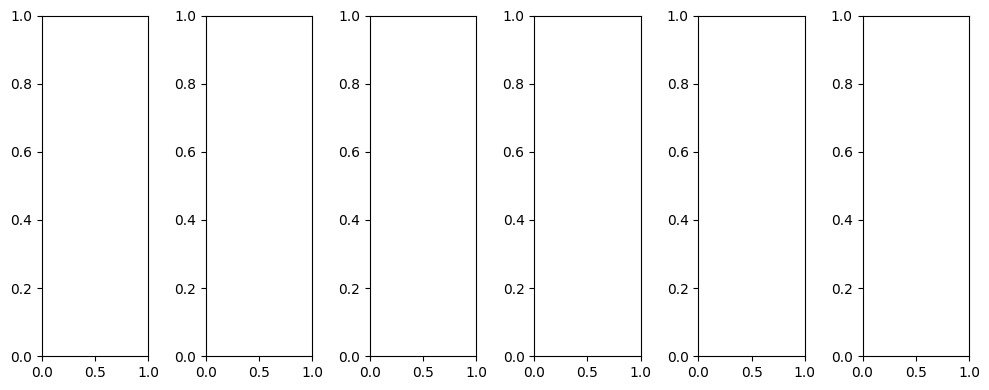

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-0.9999, -0.9999, -0.9999, -1.0000, -0.9999, -0.9998, -0.9999, -0.9999,
         -0.9998, -1.0000, -0.9996, -0.9999, -0.9997, -0.9999, -0.9999, -1.0000,
         -0.9998, -0.9999, -1.0000, -0.9999, -0.9999, -0.9999, -0.9999, -0.9999,
         -0.9999, -0.9999, -0.9997, -1.0000],
        [-0.9999, -0.9999, -0.9999, -0.9999, -0.9997, -1.0000, -0.9996, -1.0000,
         -0.9998, -0.9999, -1.0000, -0.9999, -1.0000, -0.9999, -1.0000, -0.9998,
         -1.0000, -0.9999, -0.9998, -0.9999, -0.9998, -0.9999, -0.9997, -1.0000,
         -1.0000, -0.9999, -1.0000, -0.9999],
        [-0.9999, -0.9998, -0.9999, -0.9998, -0.9999, -0.9999, -0.9999, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -0.9999, -0.9999, -0.9999,
         -0.9999, -0.9999, -0.9999, -1.0000],
        [-0.9999, -0.9999, -0.9999, -0.9999, -0.9998, -0.9999, -0.9999, -0.9999,
         -0.9997, -0.9977, -0.9962, -0.9798, -0.9705

tensor([[-0.9995, -0.9984, -0.9996, -0.9991, -0.9986, -0.9995, -0.9995, -0.9996,
         -0.9994, -0.9996, -0.9989, -0.9995, -0.9993, -0.9995, -0.9988, -0.9989,
         -0.9991, -0.9995, -0.9992, -0.9993, -0.9986, -0.9992, -0.9994, -0.9991,
         -0.9994, -0.9988, -0.9995, -0.9992],
        [-0.9989, -0.9991, -0.9991, -0.9991, -0.9996, -0.9997, -0.9991, -0.9995,
         -0.9986, -0.9995, -0.9991, -0.9994, -0.9993, -0.9996, -0.9988, -0.9988,
         -0.9984, -0.9993, -0.9990, -0.9992, -0.9994, -0.9989, -0.9992, -0.9995,
         -0.9995, -0.9990, -0.9988, -0.9991],
        [-0.9996, -0.9989, -0.9993, -0.9988, -0.9990, -0.9992, -0.9994, -0.9991,
         -0.9996, -0.9992, -0.9991, -0.9993, -0.9997, -0.9995, -0.9996, -0.9996,
         -0.9994, -0.9994, -0.9976, -0.9973, -0.9983, -0.9992, -0.9992, -0.9991,
         -0.9994, -0.9992, -0.9991, -0.9995],
        [-0.9991, -0.9993, -0.9988, -0.9991, -0.9988, -0.9994, -0.9988, -0.9950,
         -0.9935, -0.9924, -0.9853, -0.9868, -0.9849

tensor([[-9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01,
         -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9998e-01, -1.0000e+00, -9.9999e-01,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00,
         -9.9998e-01, -1.0000e+00, -9.9999e-01, -9.9999e-01, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9998e-01],
        [-1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00, -9.9998e-01,
         -9.9999e-01, -9.9999e-01, -9.9999e-01, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -9.9999e-01, -1.0000e+00, -9.9999e-01, -9.9999e-01, -9.9999e-01,
         -1.0000e+00, -1.0000e+00, -9.9999e-01],
        [-1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.00

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

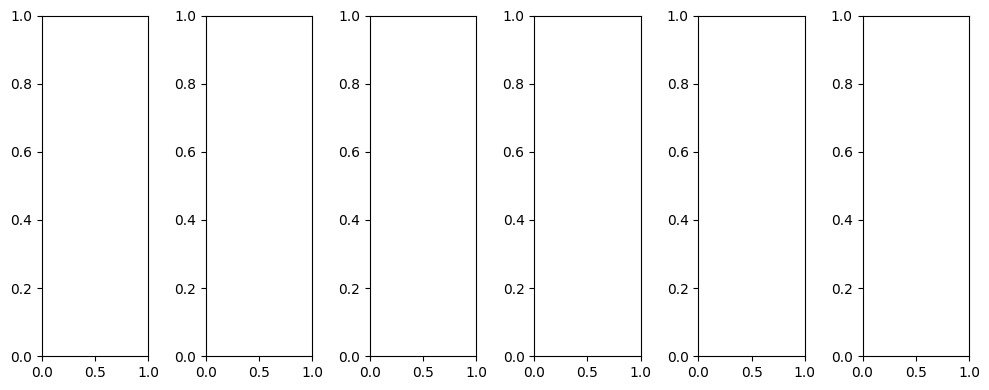

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9991, -0.9976, -0.9979, -0.9997, -0.9996, -0.9992,
         -0.9975, -0.9938, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9999, -0.9956, -0.9978, -0.9987, -0.9972

tensor([[-0.9993, -0.9995, -0.9992, -0.9990, -0.9991, -0.9993, -0.9992, -0.9991,
         -0.9992, -0.9990, -0.9992, -0.9992, -0.9992, -0.9989, -0.9988, -0.9989,
         -0.9993, -0.9992, -0.9992, -0.9995, -0.9989, -0.9992, -0.9992, -0.9989,
         -0.9995, -0.9993, -0.9993, -0.9992],
        [-0.9991, -0.9993, -0.9991, -0.9991, -0.9993, -0.9993, -0.9995, -0.9993,
         -0.9993, -0.9985, -0.9970, -0.9971, -0.9959, -0.9959, -0.9949, -0.9941,
         -0.9945, -0.9938, -0.9973, -0.9974, -0.9982, -0.9990, -0.9994, -0.9993,
         -0.9989, -0.9991, -0.9992, -0.9991],
        [-0.9993, -0.9992, -0.9994, -0.9986, -0.9990, -0.9995, -0.9995, -0.9980,
         -0.9959, -0.9956, -0.9948, -0.9927, -0.9861, -0.9824, -0.9687, -0.9428,
         -0.9107, -0.8666, -0.8297, -0.8737, -0.9157, -0.9448, -0.9820, -0.9962,
         -0.9982, -0.9992, -0.9991, -0.9990],
        [-0.9992, -0.9994, -0.9990, -0.9994, -0.9992, -0.9988, -0.9948, -0.9927,
         -0.9929, -0.9675, -0.9573, -0.9284, -0.8865

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -0.9999, -0.9994, -0.9976, -0.9890,
         -0.9790, -0.9618, -0.8702, -0.9026, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -0.9992

tensor([[-1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00, -9.9999e-01,
         -1.0000e+00, -9.9999e-01, -9.9999e-01, -9.9999e-01, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9999e-01, -9.9999e-01, -1.0000e+00,
         -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9999e-01],
        [-9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01,
         -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01, -9.9999e-01,
         -1.00

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9992,
         -0.9978, -0.8955, -0.9374, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9999, -1.0000, -0.9999, -1.0000

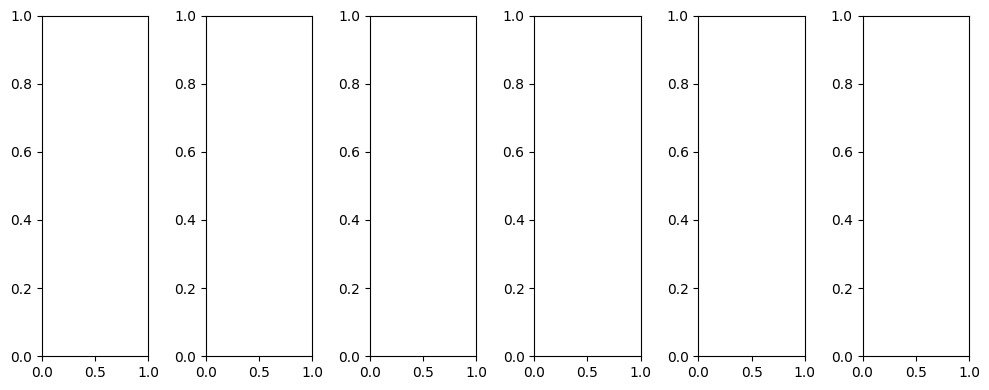

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000,
         -1.0000, -0.9999, -0.9999, -1.0000, -1.0000, -0.9999, -0.9997, -0.9998,
         -0.9996, -0.9998, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -0.9999,
         -0.9968, -0.9820, -0.9963, -0.9965, -0.9930

tensor([[-0.9995, -0.9995, -0.9994, -0.9993, -0.9993, -0.9995, -0.9992, -0.9993,
         -0.9994, -0.9992, -0.9994, -0.9993, -0.9995, -0.9991, -0.9991, -0.9990,
         -0.9995, -0.9994, -0.9993, -0.9995, -0.9991, -0.9993, -0.9994, -0.9992,
         -0.9996, -0.9994, -0.9994, -0.9993],
        [-0.9994, -0.9994, -0.9992, -0.9992, -0.9995, -0.9994, -0.9997, -0.9994,
         -0.9994, -0.9984, -0.9973, -0.9969, -0.9955, -0.9961, -0.9946, -0.9938,
         -0.9947, -0.9935, -0.9977, -0.9976, -0.9984, -0.9992, -0.9995, -0.9994,
         -0.9991, -0.9993, -0.9993, -0.9993],
        [-0.9994, -0.9994, -0.9996, -0.9990, -0.9992, -0.9996, -0.9996, -0.9977,
         -0.9953, -0.9948, -0.9929, -0.9888, -0.9772, -0.9689, -0.9494, -0.9136,
         -0.8813, -0.8600, -0.8616, -0.9040, -0.9339, -0.9536, -0.9850, -0.9967,
         -0.9986, -0.9994, -0.9993, -0.9993],
        [-0.9995, -0.9996, -0.9992, -0.9994, -0.9994, -0.9990, -0.9950, -0.9918,
         -0.9914, -0.9646, -0.9590, -0.9222, -0.8660

tensor([[-0.9996, -0.9993, -0.9998, -0.9997, -0.9997, -0.9996, -0.9997, -0.9998,
         -0.9997, -0.9999, -0.9998, -0.9998, -0.9995, -0.9998, -0.9997, -0.9996,
         -0.9996, -0.9999, -0.9997, -0.9996, -0.9998, -0.9996, -0.9998, -0.9998,
         -0.9997, -0.9998, -0.9998, -0.9995],
        [-0.9997, -0.9998, -0.9997, -0.9997, -0.9998, -0.9998, -0.9996, -0.9997,
         -0.9995, -0.9996, -0.9995, -0.9997, -0.9998, -0.9996, -0.9996, -0.9997,
         -0.9998, -0.9997, -0.9996, -0.9997, -0.9997, -0.9998, -0.9998, -0.9999,
         -0.9997, -0.9992, -0.9997, -0.9997],
        [-0.9997, -0.9992, -0.9996, -0.9997, -0.9997, -0.9997, -0.9998, -0.9995,
         -0.9998, -0.9997, -0.9993, -0.9994, -0.9996, -0.9990, -0.9992, -0.9995,
         -0.9990, -0.9992, -0.9992, -0.9995, -0.9994, -0.9995, -0.9998, -0.9997,
         -0.9998, -0.9998, -0.9998, -0.9998],
        [-0.9996, -0.9998, -0.9996, -0.9998, -0.9998, -0.9997, -0.9995, -0.9989,
         -0.9971, -0.9957, -0.9943, -0.9914, -0.9897

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9999, -0.9984, -0.9955, -0.9969, -0.9980, -0.9994, -0.9958,
         -0.9994, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9180,
         -0.9867, -0.7871, -0.7188, -0.6488, -0.6411

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9994, -0.9999, -1.0000, -0.9999, -0.9997, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -0.9997,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9999, -1.0000, -1.0000,
         -1.0000, -0.9999, -0.9999, -1.0000, -1.0000, -1.0000, -0.9998, -1.0000,
         -1.0000, -0.9999, -1.0000, -0.9998, -0.9999, -1.0000, -0.9998, -0.9999,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9997, -0.9999,
         -0.9999, -0.9997, -0.9983, -1.0000, -0.9993, -0.9940, -0.9927, -0.9919,
         -0.9996, -0.9998, -1.0000, -0.9996, -0.9997, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9995, -1.0000, -0.9999],
        [-1.0000, -0.9995, -1.0000, -1.0000, -0.9998, -0.9999, -0.9993, -0.9996,
         -0.9796, -0.8526, -0.9282, -0.9157, -0.9542

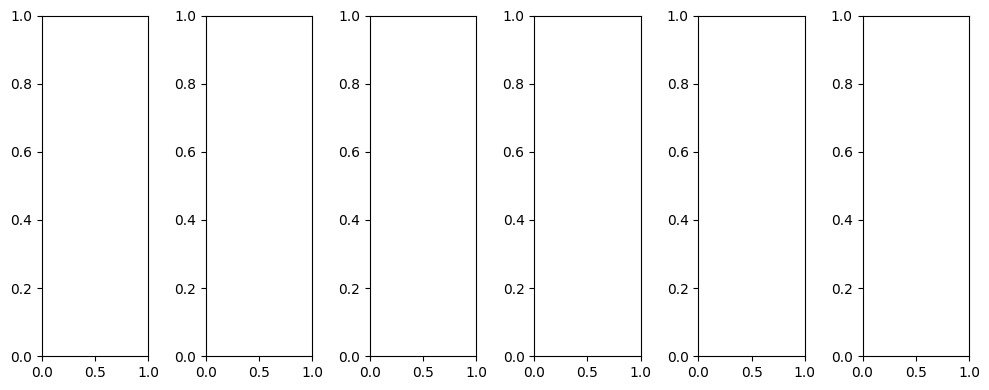

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -0.9998, -0.9999, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -0.9999, -1.0000, -1.0000, -0.9999, -0.9999, -0.9999, -1.0000,
         -0.9999, -1.0000, -0.9999, -1.0000, -1.0000, -0.9999, -1.0000, -0.9999,
         -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9999, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -0.9999,
         -1.0000, -0.9996, -0.9998, -0.9994, -0.9996, -0.9990, -0.9998, -0.9997,
         -0.9998, -0.9999, -0.9999, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9999, -0.9999, -1.0000, -1.0000, -0.9991,
         -0.9994, -0.9988, -0.9992, -0.9990, -0.9978, -0.9993, -0.9995, -0.9997,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -0.9997, -0.9975,
         -0.9986, -0.9977, -0.9925, -0.9946, -0.9961

tensor([[-1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -0.9999, -0.9999, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9999, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9999, -0.9998, -0.9999, -0.9997, -0.9998, -0.9999, -1.0000, -1.0000,
         -0.9999, -0.9999, -0.9999, -0.9999, -1.0000, -0.9999, -1.0000, -0.9999,
         -1.0000, -1.0000, -1.0000, -0.9999],
        [-1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -0.9999, -0.9999,
         -0.9998, -0.9996, -0.9995, -0.9999, -0.9999, -0.9999, -0.9999, -0.9999,
         -0.9998, -0.9999, -0.9994, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9999, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -0.9999, -0.9991,
         -0.9998, -0.9997, -0.9997, -0.9996, -0.9997

tensor([[-9.9998e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -9.9999e-01, -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9996e-01, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9999e-01],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00,
         -9.9999e-01, -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9998e-01, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9999e-01],
        [-9.9997e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9999e-01, -9.9999e-01, -9.9999e-01,
         -1.00

tensor([[-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -9.99

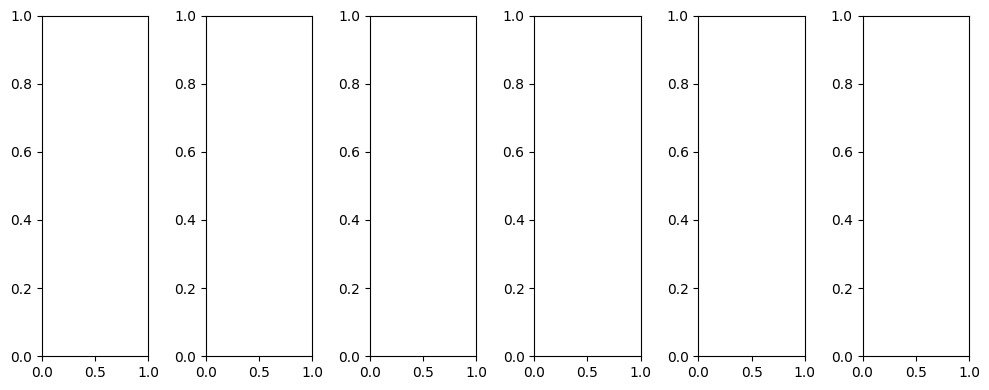

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9997, -0.9994, -0.9986, -1.0000, -0.9999, -0.9998,
         -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9997,
         -0.9998, -0.9888, -0.9365, -0.9017, -0.8291

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9999, -0.9999, -0.9930, -0.9918

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9991,
         -0.9819, -0.9706, -0.7894, -0.7969, -0.6004

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9997,
         -1.0000, -0.9828, -0.9796, -0.9318, -0.8569

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9923, -0.9858, -0.9717, -0.9653

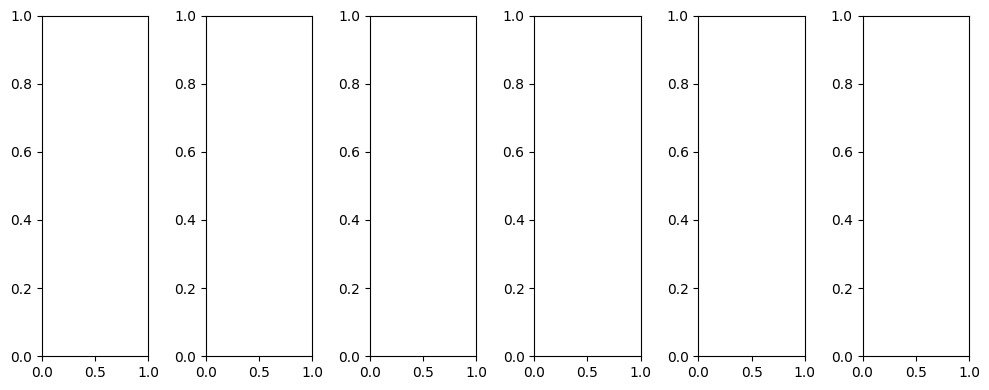

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-9.9998e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01,
         -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -9.9997e-01, -1.0000e+00, -1.0000e+00],
        [-9.9998e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -9.9996e-01, -1.0000e+00, -9.9999e-01, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9996e-01],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00,
         -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.00

tensor([[-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.00

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

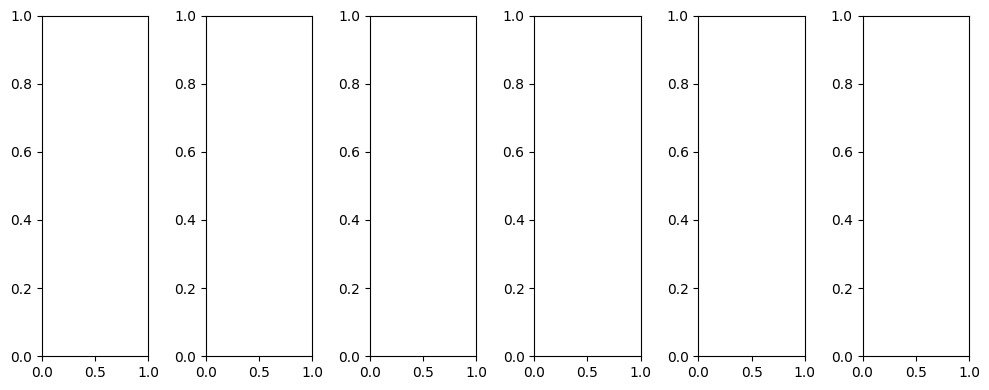

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999,
         -1.0000, -0.9999, -0.9999, -0.9999, -0.9998, -1.0000, -0.9999, -0.9996,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000,
         -0.9994, -0.9994, -0.9997, -0.9987, -0.9992

tensor([[-1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9999, -1.0000],
        [-1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999,
         -1.0000, -0.9988, -0.9985, -0.9957, -0.9934, -0.9984, -0.9990, -0.9990,
         -0.9995, -0.9995, -0.9998, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
         -0.9999, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9952,
         -0.9864, -0.9821, -0.9836, -0.9829, -0.9854, -0.9959, -0.9991, -0.9993,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -0.9999,
         -1.0000, -0.9999, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -0.9970, -0.9856,
         -0.9852, -0.9744, -0.9658, -0.9721, -0.9754

tensor([[-9.9987e-01, -9.9966e-01, -9.9978e-01, -9.9981e-01, -9.9991e-01,
         -9.9981e-01, -9.9990e-01, -9.9985e-01, -9.9989e-01, -9.9991e-01,
         -9.9991e-01, -9.9991e-01, -9.9976e-01, -9.9992e-01, -9.9970e-01,
         -9.9983e-01, -9.9995e-01, -9.9985e-01, -9.9994e-01, -9.9979e-01,
         -9.9976e-01, -9.9962e-01, -9.9981e-01, -9.9982e-01, -9.9986e-01,
         -9.9988e-01, -9.9953e-01, -9.9990e-01],
        [-9.9990e-01, -9.9991e-01, -9.9995e-01, -9.9982e-01, -9.9977e-01,
         -9.9991e-01, -9.9973e-01, -9.9981e-01, -9.9948e-01, -9.9841e-01,
         -9.9785e-01, -9.9628e-01, -9.9775e-01, -9.9743e-01, -9.9969e-01,
         -9.9969e-01, -9.9981e-01, -9.9931e-01, -9.9970e-01, -9.9951e-01,
         -9.9986e-01, -9.9975e-01, -9.9993e-01, -9.9952e-01, -9.9986e-01,
         -9.9989e-01, -9.9990e-01, -9.9989e-01],
        [-9.9984e-01, -9.9991e-01, -9.9991e-01, -9.9976e-01, -9.9935e-01,
         -9.9990e-01, -9.9942e-01, -9.9748e-01, -9.9303e-01, -9.8937e-01,
         -9.80

tensor([[-9.9998e-01, -1.0000e+00, -9.9999e-01, -9.9999e-01, -1.0000e+00,
         -9.9999e-01, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9998e-01, -1.0000e+00,
         -9.9999e-01, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -9.9999e-01],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9998e-01, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01, -9.9999e-01,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01,
         -9.9998e-01, -9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01, -1.0000e+00,
         -1.0000e+00, -9.9999e-01, -9.9999e-01],
        [-9.9999e-01, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         -1.0000e+00, -9.9999e-01, -9.9999e-01, -9.9991e-01, -9.9994e-01,
         -9.99

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -0.9998, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000,
         -1.0000, -0.9998, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999,
         -0.9999, -0.9996, -0.9994, -0.9985, -0.9992

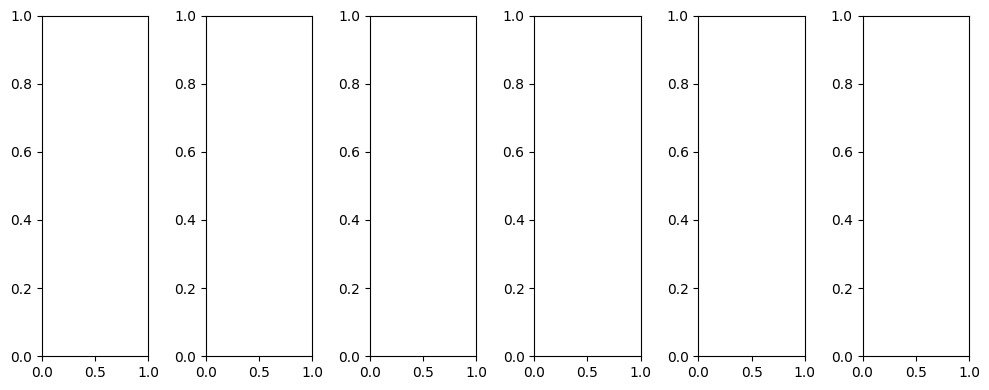

In [26]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()